In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [5]:
import hopsworks

project = hopsworks.login()

feature_store = project.get_feature_store(name='thanoojl_featurestore')
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-05-11 06:13:54,360 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-11 06:13:54,372 INFO: Initializing external client
2025-05-11 06:13:54,373 INFO: Base URL: https://c.app.hopsworks.ai:443




To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'


2025-05-11 06:13:54,972 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214697


In [6]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1214697/fs/1202332/fv/citi_bike_ds/version/1
Feature view 'citi_bike_ds' (version 1) created successfully.
Feature view 'citi_bike_ds' (version 1) retrieved successfully.


In [7]:
ts_data, _ = feature_view.training_data(
    description="Time-series 6 hour forecasting",
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 


In [8]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [9]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-12-31 18:00:00+00:00,5626,4
1,2024-01-01 00:00:00+00:00,5626,49
2,2024-01-01 06:00:00+00:00,5626,42
3,2024-01-01 12:00:00+00:00,5626,114
4,2024-01-01 18:00:00+00:00,5626,57


In [10]:
ts_data["pickup_hour"].min()

'2023-12-31 18:00:00+00:00'

In [17]:
ts_data["pickup_hour"].max()

Timestamp('2025-03-04 07:00:00')

In [11]:
ts_data_copy = ts_data.copy()

In [12]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [13]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   pickup_hour         7905 non-null   datetime64[ns, UTC]
 1   pickup_location_id  7905 non-null   int32              
 2   rides               7905 non-null   int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 123.6 KB


In [14]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [15]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         7905 non-null   datetime64[ns]
 1   pickup_location_id  7905 non-null   int32         
 2   rides               7905 non-null   int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 123.6 KB


In [16]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [17]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-12-31 18:00:00,5626,4,2023-12
1,2024-01-01 00:00:00,5626,49,2024-01
2,2024-01-01 06:00:00,5626,42,2024-01
3,2024-01-01 12:00:00,5626,114,2024-01
4,2024-01-01 18:00:00,5626,57,2024-01
...,...,...,...,...
7900,2025-05-10 00:00:00,6072,8,2025-05
7901,2025-05-10 06:00:00,6072,74,2025-05
7902,2025-05-10 12:00:00,6072,98,2025-05
7903,2025-05-10 18:00:00,6072,26,2025-05


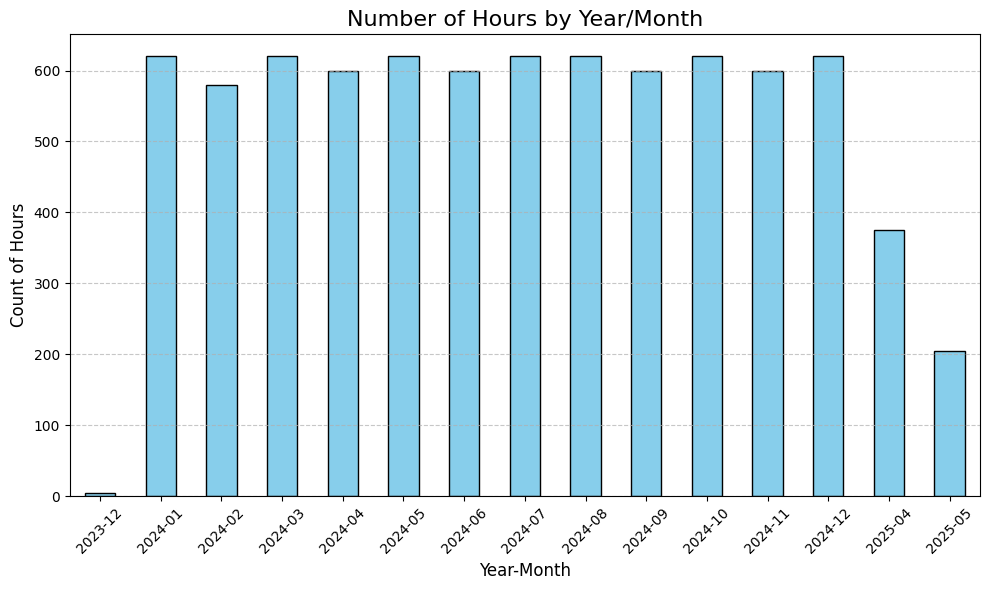

In [18]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [19]:
ts_data.head()

,pickup_hour,pickup_location_id,rides,year_month
0,2023-12-31 18:00:00,5626,4,2023-12
1,2024-01-01 00:00:00,5626,49,2024-01
2,2024-01-01 06:00:00,5626,42,2024-01
3,2024-01-01 12:00:00,5626,114,2024-01
4,2024-01-01 18:00:00,5626,57,2024-01


In [21]:
gte = ts_data["year_month"] >= pd.Period("2024-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2024-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [22]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [23]:
filtered_data.shape

(7320, 3)

In [24]:
ts_data = filtered_data

In [25]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7320 entries, 0 to 7319
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pickup_hour         7320 non-null   datetime64[ns]
 1   pickup_location_id  7320 non-null   int32         
 2   rides               7320 non-null   int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 114.5 KB


In [26]:
ts_data.head()["pickup_hour"].values

array(['2024-01-01T00:00:00.000000000', '2024-01-01T06:00:00.000000000',
       '2024-01-01T12:00:00.000000000', '2024-01-01T18:00:00.000000000',
       '2024-01-02T00:00:00.000000000'], dtype='datetime64[ns]')

In [27]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=4*28, step_size=1)

In [28]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-112,rides_t-111,rides_t-110,rides_t-109,rides_t-108,rides_t-107,rides_t-106,rides_t-105,rides_t-104,rides_t-103,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,49,42,114,57,7,110,112,86,14,103,...,39,66,205,111,26,30,56,70,2024-01-29 00:00:00,5626
1,42,114,57,7,110,112,86,14,103,135,...,66,205,111,26,30,56,70,12,2024-01-29 06:00:00,5626
2,114,57,7,110,112,86,14,103,135,97,...,205,111,26,30,56,70,12,112,2024-01-29 12:00:00,5626
3,57,7,110,112,86,14,103,135,97,10,...,111,26,30,56,70,12,112,123,2024-01-29 18:00:00,5626
4,7,110,112,86,14,103,135,97,10,128,...,26,30,56,70,12,112,123,99,2024-01-30 00:00:00,5626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,108,11,160,180,115,15,162,192,111,9,...,26,15,37,131,69,10,63,171,2024-12-30 18:00:00,6072
6756,11,160,180,115,15,162,192,111,9,139,...,15,37,131,69,10,63,171,80,2024-12-31 00:00:00,6072
6757,160,180,115,15,162,192,111,9,139,162,...,37,131,69,10,63,171,80,15,2024-12-31 06:00:00,6072
6758,180,115,15,162,192,111,9,139,162,120,...,131,69,10,63,171,80,15,87,2024-12-31 12:00:00,6072


In [29]:
features[features["pickup_location_id"] == 6072]

,rides_t-112,rides_t-111,rides_t-110,rides_t-109,rides_t-108,rides_t-107,rides_t-106,rides_t-105,rides_t-104,rides_t-103,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
5408,37,26,95,44,9,84,135,86,9,109,...,25,83,246,144,33,32,63,51,2024-01-29 00:00:00,6072
5409,26,95,44,9,84,135,86,9,109,152,...,83,246,144,33,32,63,51,11,2024-01-29 06:00:00,6072
5410,95,44,9,84,135,86,9,109,152,108,...,246,144,33,32,63,51,11,108,2024-01-29 12:00:00,6072
5411,44,9,84,135,86,9,109,152,108,10,...,144,33,32,63,51,11,108,166,2024-01-29 18:00:00,6072
5412,9,84,135,86,9,109,152,108,10,127,...,33,32,63,51,11,108,166,97,2024-01-30 00:00:00,6072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,108,11,160,180,115,15,162,192,111,9,...,26,15,37,131,69,10,63,171,2024-12-30 18:00:00,6072
6756,11,160,180,115,15,162,192,111,9,139,...,15,37,131,69,10,63,171,80,2024-12-31 00:00:00,6072
6757,160,180,115,15,162,192,111,9,139,162,...,37,131,69,10,63,171,80,15,2024-12-31 06:00:00,6072
6758,180,115,15,162,192,111,9,139,162,120,...,131,69,10,63,171,80,15,87,2024-12-31 12:00:00,6072


In [30]:
features_copy = features.copy()

In [31]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(6760, 115)

In [61]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=29))
# cutoff_date = datetime(2024, 10, 1, 0, 0, 0)
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-04-12 07:28:09.932933')

In [62]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6760, 114)
(6760,)
(0, 114)
(0,)


In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6760 entries, 0 to 6759
Columns: 114 entries, rides_t-112 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(112)
memory usage: 5.9 MB


In [64]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [65]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28831
[LightGBM] [Info] Number of data points in the train set: 6760, number of used features: 116
[LightGBM] [Info] Start training from score 192.068787


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x00000242288B8040>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('standardscaler', StandardScaler()),
                ('lgbmregressor', LGBMRegressor())])

In [67]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(X_train)

In [68]:
predictions

array([ 17.7023534 , 100.67630399, 116.19559527, ...,  84.63164801,
       144.346807  ,  62.47226046])

In [69]:
test_mae = mean_absolute_error(y_train, predictions)
print(f"{test_mae:.4f}")

16.3830


In [70]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['C:\\Users\\thano\\Documents\\University\\CDA500\\citi_bike\\models\\lgb_model.pkl']

In [71]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [72]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="citybike_lgb_model",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=X_train.sample(),
    model_schema=model_schema,
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save(f'{config.MODELS_DIR}\lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/294151 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/568 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/8858 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1214697/models/citybike_lgb_model/2


Model(name: 'citybike_lgb_model', version: 2)

In [76]:
from src.inference import load_model_from_registry
print(config.MODEL_NAME)
model = load_model_from_registry()

citybike_lgb_model
2025-05-11 07:39:47,140 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-11 07:39:47,142 INFO: Initializing external client
2025-05-11 07:39:47,142 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-05-11 07:39:47,707 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214697


In [77]:
from src.inference import get_model_predictions

In [78]:
preds = get_model_predictions(model, features_copy)

In [79]:
model.get_metadata_routing

<bound method Pipeline.get_metadata_routing of Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x00000242288B8040>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('standardscaler', StandardScaler()),
                ('lgbmregressor', LGBMRegressor())])>

In [80]:
preds

,pickup_location_id,predicted_demand
0,5626,18.0
1,5626,101.0
2,5626,116.0
3,5626,94.0
4,5626,17.0
...,...,...
6755,6072,89.0
6756,6072,14.0
6757,6072,85.0
6758,6072,144.0


In [81]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

16.3799
